In [4]:
import rasterio
import xarray as xr

In [42]:
import affine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np

In [225]:
src = rasterio.open("../raw_data/rasters/hk_ndvi.tif", 
                    dtype = "uint8", 
                    nodata = 0, tiled = True)

In [226]:
# access the only band
band = src.read(1)

In [227]:
# double-check band values range, without NA or <-3e+38
np.quantile(band.flatten()[band.flatten() > -3e+38], .95)

0.39309183359146116

In [ ]:
# -3e+38 is NA in GIS language

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


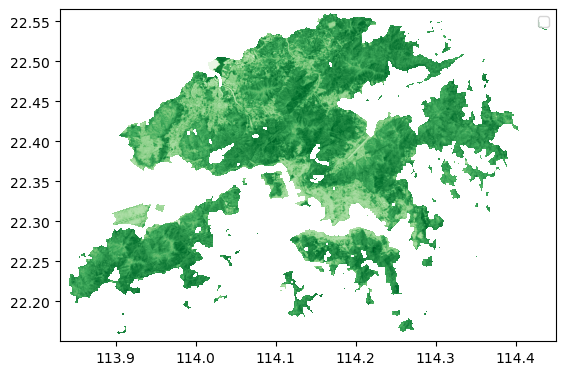

In [166]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='Greens')

plt.plot(ax=ax)

In [290]:
src = xr.open_rasterio('../raw_data/rasters/hk_ndvi.tif').squeeze("band", drop = True)

/var/folders/qj/hf26mvwj06q4f45ybdkdprgw0000gn/T/ipykernel_5354/3155226053.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  src = xr.open_rasterio('../raw_data/rasters/hk_ndvi.tif').squeeze("band", drop = True)


In [241]:
src.values.min()

-3.4e+38

In [235]:
import rasterio.features
import shapely.geometry as sg

In [242]:
def polygonize(da: xr.DataArray) -> gpd.GeoDataFrame:
    """
    Polygonize a 2D-DataArray into a GeoDataFrame of polygons.

    Parameters
    ----------
    da : xr.DataArray

    Returns
    -------
    polygonized : geopandas.GeoDataFrame
    """
    if da.dims != ("y", "x"):
        raise ValueError('Dimensions must be ("y", "x")')

    values = da.values
    transform = da.attrs.get("transform", None)
    if transform is None:
        raise ValueError("transform is required in da.attrs")
    transform = affine.Affine(*transform)
    shapes = rasterio.features.shapes(values, transform=transform)

    geometries = []
    colvalues = []
    for (geom, colval) in shapes:
        if colval > -3e+38:
            geometries.append(sg.Polygon(geom["coordinates"][0]))
            colvalues.append(colval)

    gdf = gpd.GeoDataFrame({"value": colvalues, "geometry": geometries})
    gdf.crs = da.attrs.get("crs")
    return gdf


In [291]:
vegedata = polygonize(src)

/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [292]:
vegedata["value"].head()

0    0.092215
1    0.092293
2    0.114464
3    0.121832
4    0.115413
Name: value, dtype: float64

# todo: 
due to too many fragments in the vegetation map
bin the NVDI by 100 bins? then cascaded union?

In [285]:
bins = np.linspace(vegedata["value"].min(), vegedata["value"].max(), 100)
vegedata_binned = vegedata
vegedata_binned["value"] = np.digitize(vegedata["value"], 
                                       bins) / (vegedata["value"].max() - vegedata["value"].min()) - vegedata["value"].min()

In [286]:
from shapely.ops import unary_union
vegedata_binned = vegedata_binned.groupby("value").apply(lambda x: unary_union(x["geometry"]))

/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [288]:
vegedata

value                                           geometry
0        42.989899  POLYGON ((114.16125 22.56208, 114.16125 22.561...
1        42.989899  POLYGON ((114.16069 22.56181, 114.16069 22.561...
2        44.989899  POLYGON ((114.16097 22.56181, 114.16097 22.561...
3        45.989899  POLYGON ((114.16125 22.56181, 114.16125 22.561...
4        44.989899  POLYGON ((114.16153 22.56181, 114.16153 22.561...
...            ...                                                ...
1246334  52.989899  POLYGON ((113.92236 22.15431, 113.92236 22.154...
1246335  52.989899  POLYGON ((113.92264 22.15431, 113.92264 22.154...
1246336  34.989899  POLYGON ((113.92236 22.15403, 113.92236 22.153...
1246337  25.989899  POLYGON ((113.92208 22.15375, 113.92208 22.153...
1246338  26.989899  POLYGON ((113.92236 22.15375, 113.92236 22.153...

[1246339 rows x 2 columns]

# hk border

In [38]:
border_gpd = gpd.read_file("../raw_data/rasters/HK_border.shp")
border_gpd = border_gpd["geometry"][0]

In [39]:
border_gpd

# import ha district polygons

In [73]:
district_gpd = gpd.read_file("district_map.shp")

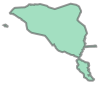

In [77]:
district_gpd["geometry"][2].intersection(border_gpd)

In [78]:
for i in range(len(district_gpd)):
    district_gpd["geometry"][i] = district_gpd["geometry"][i].intersection(border_gpd)

In [79]:
district_gpd.to_file("district_land_map.shp")

# finding out vegetation

In [250]:
vegedata.head()

value                                           geometry
0  0.092215  POLYGON ((114.16125 22.56208, 114.16125 22.561...
1  0.092293  POLYGON ((114.16069 22.56181, 114.16069 22.561...
2  0.114464  POLYGON ((114.16097 22.56181, 114.16097 22.561...
3  0.121832  POLYGON ((114.16125 22.56181, 114.16125 22.561...
4  0.115413  POLYGON ((114.16153 22.56181, 114.16153 22.561...

In [251]:
def find_vege(district, vege_gpd):
    vege = 0
    cutout = district.centroid
    landarea = district.area
    for i in range(0,len(vege_gpd["geometry"])):
        if district.intersects(vege_gpd["geometry"][i]):
            intersect = district.intersection(vege_gpd["geometry"][i])
            # cutout = cutout.union(intersect)
            vege += vege_gpd["value"][i] * intersect.area
            
    return (vege, landarea)

In [252]:
# print(district_gpd["Districtcode"][0], district_gpd["Districtname"][0])
i = 0
(vege, landarea) = find_vege(district_gpd["geometry"][i], vegedata)


ABERDEEN vegetation coverage 23.9 %


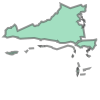

In [260]:
print(district_gpd["Districtna"][i],
      "vegetation coverage",
      round(vege / landarea, 3) * 100, 
     "%")
district_gpd["geometry"][i]

In [261]:
df = district_gpd
vege_over_land = []
for i in range(len(df)):
    # print(i)
    if i % 10 == 0:
        print(f"Finished {i} HA districts")
    vege, landarea = find_vege(df["geometry"][i], vegedata)
    
    # print(road / zoned, type(road_over_zoned))
    if vege == 0:
        vege_over_land.append(-1)
    else:
        vege_over_land.append(vege / landarea)


Finished 0 HA districts


KeyboardInterrupt: 

In [50]:
len(vege_over_land)

118

# merging with HA district df

In [99]:
df = district_gpd
df = pd.concat([df, pd.DataFrame({"vege_over_land": vege_over_land})], axis = 1)
df["vege_over_land"] = round(df["vege_over_land"], 3)

In [100]:
# df = df[df["road_over_zoned"] != -1]

In [101]:
df = df.set_index("Districtna")

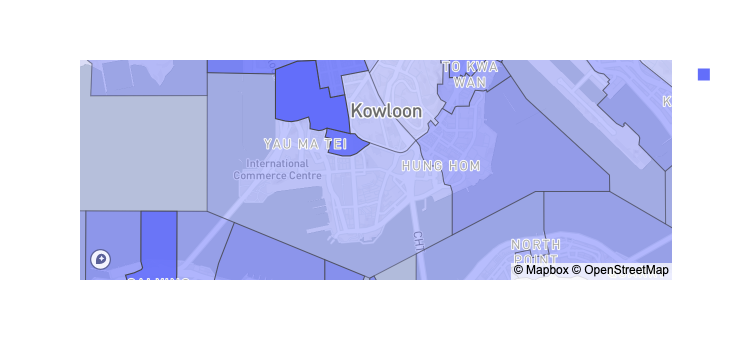

In [98]:
fig = px.choropleth_mapbox(df,
                           geojson=gpd.GeoSeries(df.geometry),
                           locations=df.index,
                           center={"lat": 22.3193, "lon": 114.1694},
                          mapbox_style="light",
                           hover_data = ["vege_over_land"],
                          opacity = df.vege_over_land / max(df.vege_over_land))
fig.show()

In [55]:
df.to_excel("ha_district_road_over_zoned.xlsx")